# Breast Cancer

## Introduction


In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pathlib import Path
from catboost import CatBoostClassifier

In [21]:
df = pd.read_csv("Cancer_Data.csv")
df.head()

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [22]:
df.shape

(683, 11)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683 entries, 0 to 682
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Sample code number           683 non-null    int64
 1   Clump Thickness              683 non-null    int64
 2   Uniformity of Cell Size      683 non-null    int64
 3   Uniformity of Cell Shape     683 non-null    int64
 4   Marginal Adhesion            683 non-null    int64
 5   Single Epithelial Cell Size  683 non-null    int64
 6   Bare Nuclei                  683 non-null    int64
 7   Bland Chromatin              683 non-null    int64
 8   Normal Nucleoli              683 non-null    int64
 9   Mitoses                      683 non-null    int64
 10  Class                        683 non-null    int64
dtypes: int64(11)
memory usage: 58.8 KB


**Conclusion:**
* Sample code number is not relevant to us.
* All columns are numerical data.

### Missing Data

In [24]:
df.isnull().sum()

Sample code number             0
Clump Thickness                0
Uniformity of Cell Size        0
Uniformity of Cell Shape       0
Marginal Adhesion              0
Single Epithelial Cell Size    0
Bare Nuclei                    0
Bland Chromatin                0
Normal Nucleoli                0
Mitoses                        0
Class                          0
dtype: int64

**Conclusion:** No missing data.

### Duplicated data

In [25]:
df.duplicated().sum()

np.int64(8)

**Conclusion:** There are 8 rows with duplicated data.

In [26]:
df[df.duplicated()]

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
202,1218860,1,1,1,1,1,1,3,1,1,2
245,1100524,6,10,10,2,8,10,7,3,3,4
246,1116116,9,10,10,1,10,8,3,3,1,4
250,1198641,3,1,1,1,2,1,3,1,1,2
264,320675,3,3,5,2,3,10,7,1,1,4
324,704097,1,1,1,1,1,1,2,1,1,2
546,1321942,5,1,1,1,2,1,3,1,1,2
668,466906,1,1,1,1,2,1,1,1,1,2


In [27]:
df = df[df.duplicated() == False]
df.duplicated().sum()

np.int64(0)

In [28]:
df.shape

(675, 11)

**Conclusion:** The duplicated rows are now removed.

# EDA

In [29]:
df_clean = df.drop(['Sample code number'], axis=1)
df_clean.head()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2


In [30]:
df_clean["Class"] = df_clean["Class"].map({ 2: 0, 4: 1 })

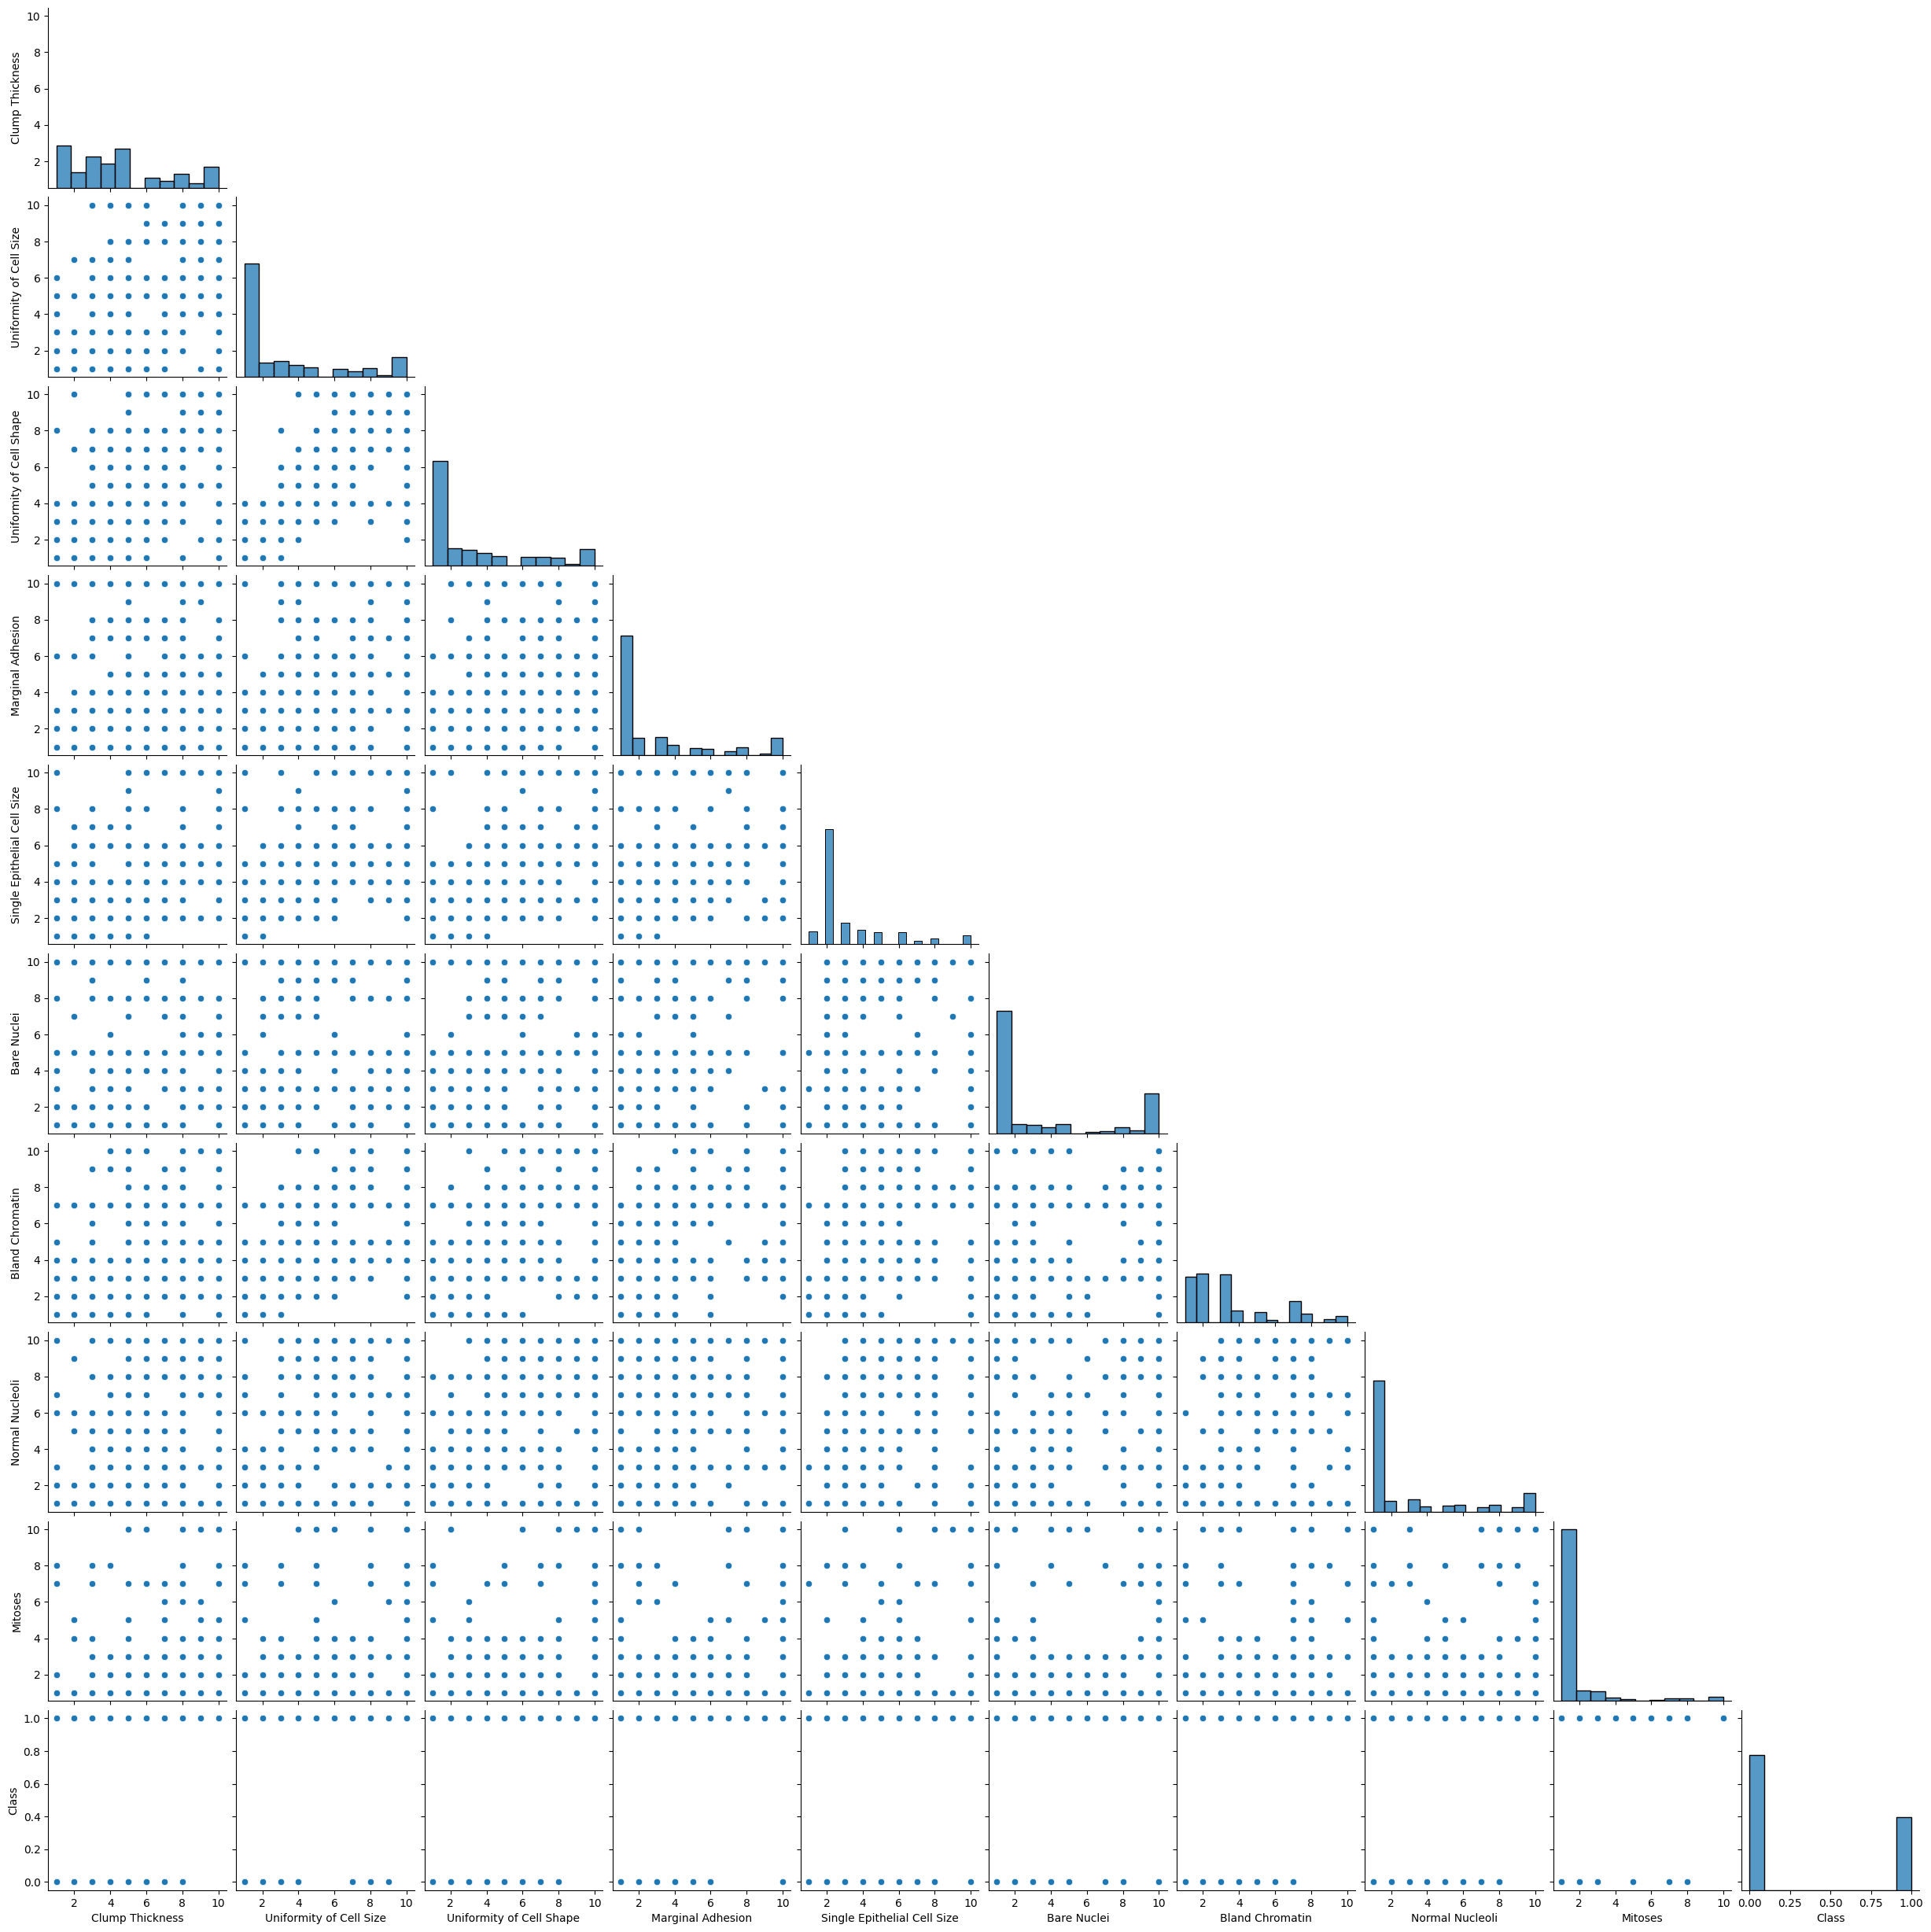

In [31]:
def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)

e = sns.pairplot(df_clean)
e.map_upper(hide_current_axis)

**Conclusion:** pair plot is not useful on this dataset.

### Counting The Malignant Tumor Cases

<Axes: title={'center': 'Average 34.96%'}, xlabel='Class', ylabel='count'>

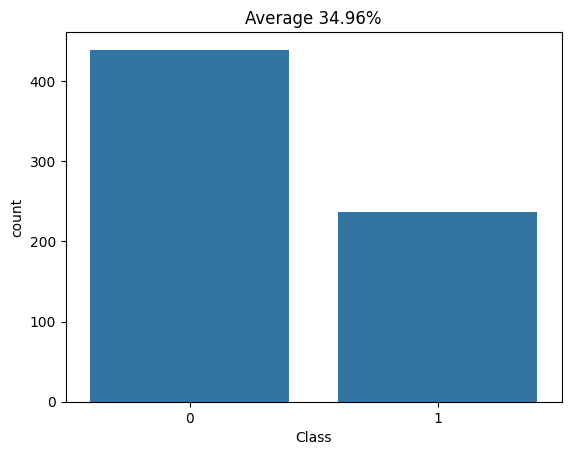

In [32]:
plt.title(f"Average {df_clean['Class'].mean()*100:.2f}%")
sns.countplot(data=df_clean, x="Class")

In [33]:
corr_matrix = df_clean.corr()
corr_matrix

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
Clump Thickness,1.000000,0.640847,0.652617,0.489421,0.519172,0.593936,0.556404,0.533891,0.351270,0.715714
Uniformity of Cell Size,0.640847,1.000000,0.905755,0.714650,0.748829,0.689895,0.759418,0.723712,0.462185,0.820663
Uniformity of Cell Shape,0.652617,0.905755,1.000000,0.694029,0.717186,0.710876,0.737873,0.723241,0.443013,0.820688
Marginal Adhesion,0.489421,0.714650,0.694029,1.000000,0.603479,0.676428,0.671744,0.602188,0.418393,0.710985
Single Epithelial Cell Size,0.519172,0.748829,0.717186,0.603479,1.000000,0.582752,0.622649,0.634129,0.484212,0.689544
Bare Nuclei,0.593936,0.689895,0.710876,0.676428,0.582752,1.000000,0.679137,0.587950,0.339792,0.820533
Bland Chromatin,0.556404,0.759418,0.737873,0.671744,0.622649,0.679137,1.000000,0.668820,0.345681,0.758252
Normal Nucleoli,0.533891,0.723712,0.723241,0.602188,0.634129,0.587950,0.668820,1.000000,0.433039,0.722020
Mitoses,0.351270,0.462185,0.443013,0.418393,0.484212,0.339792,0.345681,0.433039,1.000000,0.424399
Class,0.715714,0.820663,0.820688,0.710985,0.689544,0.820533,0.758252,0.722020,0.424399,1.000000


<Axes: >

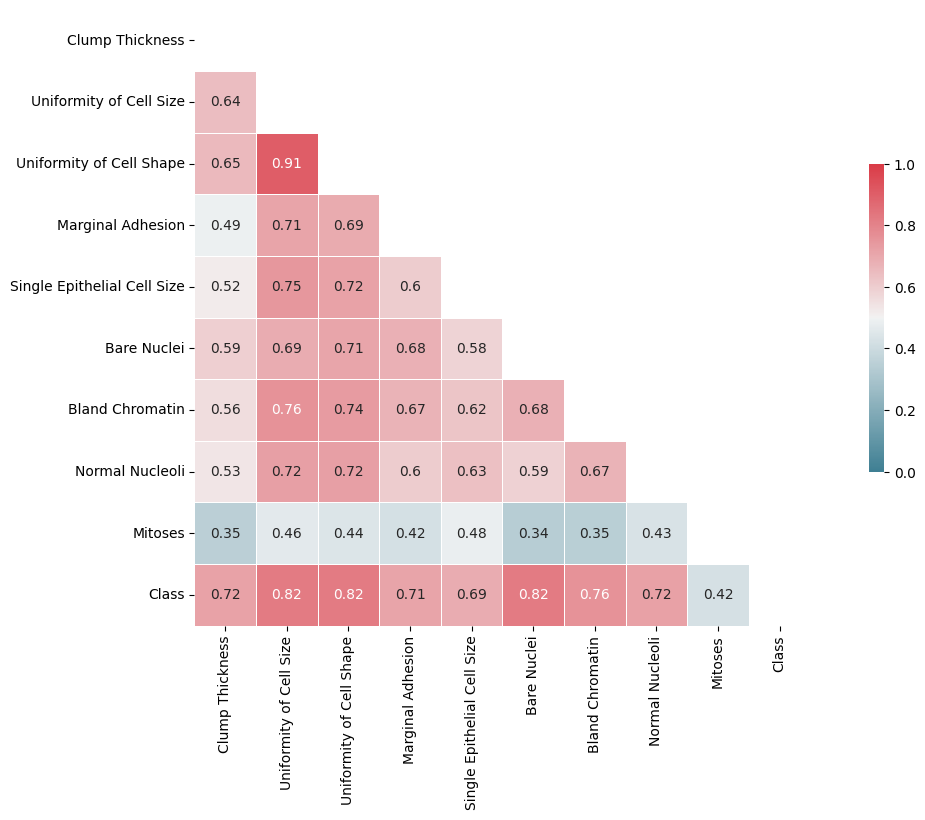

In [34]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(15, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap,  vmin=0, vmax=1, center=.5, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)

**Conclusion:**

| Value 1        | Value 2       | Value | Observation   |
| -------------- | ------------- | ----- | ------------- |
|Class          | Clump Thickness              |  +0.72  | moderate correlation |
|Class          | Uniformity of Cell Size      |  +0.82  | strong correlation |
|Class          | Uniformity of Cell Shape     |  +0.82  | strong correlation |
|Class          | Marginal Adhesion            |  +0.71  | moderate correlation |
|Class          | Single Epithelial Cell Size  |  +0.69  | moderate correlation |
|Class          | Bare Nuclei                  |  +0.82  | strong correlation |
|Class          | Bland Chromatin              |  +0.76  | moderate correlation |
|Class          | Normal Nucleoli              |  +0.72  | moderate correlation |
|Class          | Mitoses                      |  +0.42  | inverse correlation |
|Uniformity of Cell Size          | Uniformity of Cell Shape                      |  +0.91  | The Strongest correlation |

## Preprocess 

In [35]:
X = df_clean.iloc[:, :-1].values
print("X (inputs)")
print(X)

# will contains the values of the column 'class:Tumor type'
y = df_clean.iloc[:, -1].values
y = (y == 1)

print("y (outputs)")
print(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=0)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
print("X_train.shape:", X_train.shape)
print("X_train:", X_train)
print("X_test.shape:", X_test.shape)
print("X_test:", X_test)

X (inputs)
[[ 5  1  1 ...  3  1  1]
 [ 5  4  4 ...  3  2  1]
 [ 3  1  1 ...  3  1  1]
 ...
 [ 5 10 10 ...  8 10  2]
 [ 4  8  6 ... 10  6  1]
 [ 4  8  8 ... 10  4  1]]
y (outputs)
[False False False False False  True False False False False False False
  True False  True  True False False  True False  True  True False False
  True False False False False False False  True False False False  True
 False  True  True  True  True  True  True False  True False False  True
  True  True  True  True  True  True  True  True  True  True  True False
  True  True False  True False  True  True False False  True False  True
  True False False False False False False False False False  True  True
  True  True False False False False False False False False False False
  True  True  True  True False  True  True  True  True  True False  True
 False  True  True  True False False False  True False False False False
  True  True  True False  True False  True False False False  True False
 False False False

In [46]:
class my_Random_Forest:
    def __init__(self):
        self.classifier = RandomForestClassifier(
            n_estimators=10, criterion='entropy', random_state=0)
        self.classifier.fit(X_train, y_train)

    def predict(self, X_input):
        return self.classifier.predict(X_input)


class my_Decision_Tree:
    def  __init__(self):
        self.classifier = DecisionTreeClassifier(criterion='entropy', random_state=0)
        self.classifier.fit(X_train, y_train)
    
    def predict(self, X_input):
        return self.classifier.predict(X_input)

    
class my_GaussianNB:
    def __init__(self):
        self.classifier = GaussianNB()
        self.classifier.fit(X_train, y_train)

    def predict(self, X_input):
        return self.classifier.predict(X_input)

class my_SVC:
    def __init__(self):
        self.classifier = SVC(kernel='rbf', random_state=0)
        self.classifier.fit(X_train, y_train)
    def predict(self, x_input):
        return self.classifier.predict(x_input)

class my_LogisticRegression:
    def __init__(self: np.ndarray) -> np.ndarray:
        self.classifier = LogisticRegression(random_state=0, C=1)
        self.classifier.fit(X_train, y_train)
       
    def predict(self, x_input):   
        return self.classifier.predict(x_input)

class my_KNeighbors:
    def __init__(self):
        self.classifier = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
        self.classifier.fit(X_train, y_train)

    def predict(self, x_input):
        return self.classifier.predict(x_input)

class my_DeepLearning:
    def __init__(self):


        model_filepath = f"Tumor-type-nb.keras"

        model_file = Path(model_filepath)

        if model_file.exists() and model_file.is_file():

            print("model file was found")
            print("reusing previously trained model")

            ann = tf.keras.models.load_model(model_filepath)

        else:

            print("model file was not found")
            print("training new model")

            ann = tf.keras.models.Sequential()
            ann.add(tf.keras.layers.Dense(
                units=6,  activation='relu'))
            ann.add(tf.keras.layers.Dropout(rate=0.3))
            ann.add(tf.keras.layers.Dense(
                units=6,  activation='relu'))
            ann.add(tf.keras.layers.Dropout(rate=0.3))
            ann.add(tf.keras.layers.Dense(
                units=1,  activation='sigmoid'))

            ann.compile(optimizer='adam', loss='binary_crossentropy',
                        metrics=['accuracy'])

            early_stopping = tf.keras.callbacks.EarlyStopping(
                # monitor='val_loss',
                monitor='val_accuracy',
                # monitor='mean_squared_error',

                # how long with no progress do we insist?
                patience=300,

                restore_best_weights=True,
                verbose=1
            )

            ann.fit(
                X_train, y_train,
                epochs=300,
                batch_size=32,
                validation_data=(X_test, y_test),
                callbacks=[early_stopping],
                verbose=1
            )

            ann.save(model_filepath)

       
        self.ann = ann

    def predict(self, X_input):

        y_pred = self.ann.predict(X_input, verbose=0)
        return y_pred
    
class my_Catboost:
    def __init__(self):
        self.classifier = CatBoostClassifier()
        model_filepath = "my_Catboost.model"

        model_file = Path(model_filepath)

        if model_file.exists() and model_file.is_file():
            self.classifier.load_model(model_filepath)
        else:
            self.classifier.fit(X_train, y_train, verbose=0)
            self.classifier.save_model(model_filepath)

    def predict(self, X_input):
        return self.classifier.predict(X_input)

      

In [48]:
class my_prediction_class:
    name: str
    y_pred: np.ndarray
    accuracy_score: float

    def __init__(self, name: str, predictor):
        self.name = name
        self.predictor = predictor
        self.y_pred = self.predictor.predict(X_test)
        self.y_pred = self.y_pred > 0.5
        self.accuracy_score = accuracy_score(y_test, self.y_pred)


all_predictions: list[my_prediction_class] = []


my_predictor = my_Random_Forest()
all_predictions.append(my_prediction_class(
    "random forest     ", my_predictor))
my_predictor = my_Decision_Tree()
all_predictions.append(my_prediction_class(
    "decision tree     ", my_predictor))
my_predictor = my_GaussianNB()
all_predictions.append(my_prediction_class(
    "GaussianNB        ", my_predictor))

my_predictor = my_LogisticRegression()
all_predictions.append(my_prediction_class(
    "LogisticRegression", my_predictor))

my_predictor = my_KNeighbors()
all_predictions.append(my_prediction_class(
    "KNeighbors        ", my_predictor))

my_predictor = my_DeepLearning()
all_predictions.append(my_prediction_class(
    "deep learning     ", my_predictor))

my_predictor = my_SVC()
all_predictions.append(my_prediction_class(
    "svc               ", my_predictor))

my_predictor = my_Catboost()
all_predictions.append(my_prediction_class(
    "Catboost          ", my_predictor))

# my_predictor = my_xgboost()
# all_predictions.append(my_prediction_class(
#     "xgboost           ", my_predictor))

print("unsorted")
for curr_values in all_predictions:
    print(f"-> {curr_values.name} {curr_values.accuracy_score:.3f}")

# sort by score


def my_sort_func_by_score(values: my_prediction_class):
    return values.accuracy_score


all_predictions.sort(reverse=True, key=my_sort_func_by_score)

print("sorted")
for curr_values in all_predictions:
    print(f"-> {curr_values.name} {curr_values.accuracy_score:.3f}")




model file was found
reusing previously trained model
unsorted
-> random forest      0.978
-> decision tree      0.948
-> GaussianNB         0.985
-> LogisticRegression 0.985
-> KNeighbors         0.985
-> deep learning      0.993
-> svc                0.993
-> Catboost           0.985
sorted
-> deep learning      0.993
-> svc                0.993
-> GaussianNB         0.985
-> LogisticRegression 0.985
-> KNeighbors         0.985
-> Catboost           0.985
-> random forest      0.978
-> decision tree      0.948


In [49]:
# Does 'X' person has breast cancer?

def predict_one_person_data(
        Clump, uniformity_Cell_Size, uniformity_Cell_Shape, Marginal_Adhesion, Single_Epithelial_Cell_Size, Bare_Nuclei, Bland_Chromatin, Normal_Nucleoli, Mitoses):

    print("=" * 30)

    # print(f"Does she with these features {Clump},{uniformity Cell Size},{Uniformity Cell Shape},{Marginal Adhesion},{Single Epithelial Cell Size}, {Bare Nuclei}, {Bland Chromatin}, {Normal Nucleoli}, {Mitoses} have breast cancer?")

    input_data = sc.transform([[Clump, uniformity_Cell_Size, uniformity_Cell_Shape, Marginal_Adhesion,
                              Single_Epithelial_Cell_Size, Bare_Nuclei, Bland_Chromatin, Normal_Nucleoli, Mitoses]])

    for curr_predict in all_predictions:

        result = curr_predict.predictor.predict(input_data)

        if result:
            message = "this person has cancer"
        else:
            message = "this person hasn't cancer"

        print(curr_predict.name, result, message)

predict_one_person_data(4, 1, 1, 3, 2, 1, 3, 1, 1)
predict_one_person_data(8, 10, 10, 8, 7, 10, 9, 7, 1)


deep learning      [[0.00102921]] this person has cancer
svc                [False] this person hasn't cancer
GaussianNB         [False] this person hasn't cancer
LogisticRegression [False] this person hasn't cancer
KNeighbors         [False] this person hasn't cancer
Catboost           [False] this person hasn't cancer
random forest      [False] this person hasn't cancer
decision tree      [False] this person hasn't cancer
deep learning      [[0.99995977]] this person has cancer
svc                [ True] this person has cancer
GaussianNB         [ True] this person has cancer
LogisticRegression [ True] this person has cancer
KNeighbors         [ True] this person has cancer
Catboost           [ True] this person has cancer
random forest      [ True] this person has cancer
decision tree      [ True] this person has cancer
